In [171]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import ConcatDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import os

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists("cgan_images"):
    os.makedirs("cgan_images")

In [174]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset1 = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataset2 = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
dataset = ConcatDataset([dataset1, dataset2])

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [175]:
def show_images(images, labels):
    images = (images + 1) / 2
    npimg = images.numpy()
    _, axes = plt.subplots(1, 8, figsize=(12, 12))

    for i in range(8):
        ax = axes[i]
        ax.imshow(npimg[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

def show_generated_imgs(generator, latent_dim, label, num_images=5):
    one_hot_labels = torch.zeros(num_images, 10).to(device)
    one_hot_labels[range(num_images), label] = 1

    z = torch.randn(num_images, latent_dim).to(device)
    z = torch.cat((z, one_hot_labels), dim=1)

    gen_imgs = generator(z)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.detach().cpu().numpy()

    _, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)).squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()

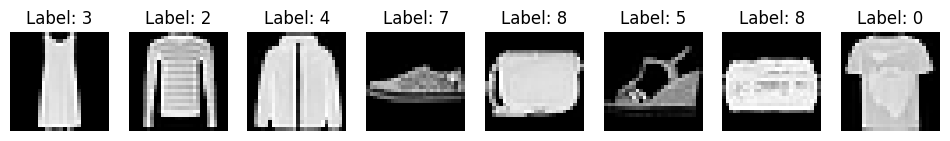

In [176]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

show_images(images, labels)

In [177]:
latent_dim = 100
encoded_conditional_noise_dim = 10
image_shape = 28 * 28

In [178]:
num_epochs = 50
learning_rate = 1e-4
b1 = 0.5
b2 = 0.999

In [179]:
generator = nn.Sequential(
    nn.Linear(latent_dim + encoded_conditional_noise_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, image_shape),
    nn.Tanh()
).to(device)

discriminator = nn.Sequential(
    nn.Linear(image_shape, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 20),
    nn.Softmax()
).to(device)

In [180]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1, b2))

criterion = nn.CrossEntropyLoss().to(device)

In [181]:
for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
    for idx, (imgs, labels) in tqdm(enumerate(dataloader), leave=False, desc="Batches", total=len(dataloader)):
        valid = labels.to(device)
        fake = labels + 10
        fake = fake.to(device)

        real_imgs = imgs.view(imgs.size(0), -1).to(device)

        optimizer_G.zero_grad()

        one_hot_labels = torch.zeros((imgs.size(0), 10)).to(device)
        one_hot_labels[range(imgs.size(0)), labels] = 1
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        z = torch.cat((z, one_hot_labels), dim=1)

        gen_imgs = generator(z)

        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()


        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    save_image(gen_imgs.data[:25], f"cgan_images/{epoch}.png", nrow=5, normalize=True)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

/Users/rmrf/miniconda3/envs/hai/lib/python3.9/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

Batches:   0%|          | 0/1094 [00:00<?, ?it/s]

- 0 T-shirt/top

- 1 Trouser

- 2 Pullover

- 3 Dress

- 4 Coat

- 5 Sandal

- 6 Shirt

- 7 Sneaker

- 8 Bag

- 9 Ankle boot

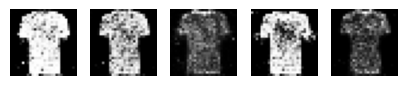

In [212]:
show_generated_imgs(generator, latent_dim, 0)

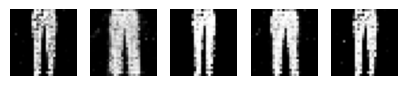

In [211]:
show_generated_imgs(generator, latent_dim, 1)

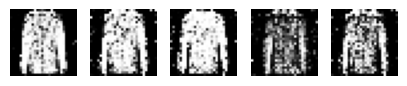

In [215]:
show_generated_imgs(generator, latent_dim, 2)

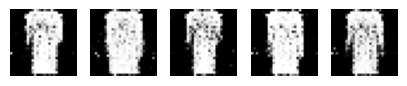

In [216]:
show_generated_imgs(generator, latent_dim, 3)

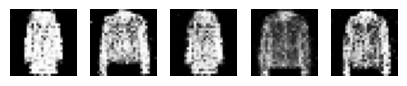

In [218]:
show_generated_imgs(generator, latent_dim, 4)

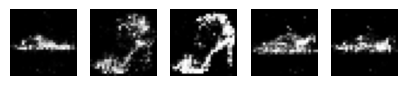

In [187]:
show_generated_imgs(generator, latent_dim, 5)

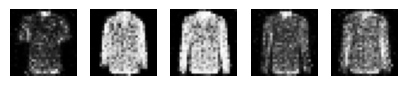

In [188]:
show_generated_imgs(generator, latent_dim, 6)

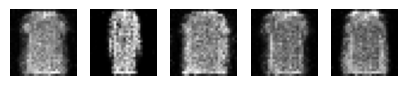

In [189]:
show_generated_imgs(generator, latent_dim, 7)

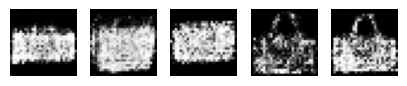

In [190]:
show_generated_imgs(generator, latent_dim, 8)

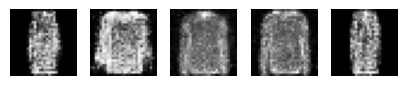

In [191]:
show_generated_imgs(generator, latent_dim, 9)

In [196]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

prediction = discriminator(images.view(images.size(0), -1).to(device)).argmax(dim=1)
answer = labels

print((prediction == answer))
print((prediction == answer).float().mean())

tensor(0.7344)


In [139]:
torch.save(generator.state_dict(), 'cgan_model_weights.pth')
torch.save(discriminator.state_dict(), 'cgan_discriminator_weights.pth')

# generator.load_state_dict(torch.load('cgan_model_weights.pth'))
# generator.eval()

# discriminator.load_state_dict(torch.load('cgan_discriminator_weights.pth'))